In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

# Comparación de distribuciones con Python: test Kolmogorov–Smirnov

> Comparación de distribuciones con Python: test Kolmogorov–Smirnov.



# Introducción

En este documento se muestran varias estrategias que permiten comparar distribuciones y detectar si existen diferencias entre ellas. En la práctica, este tipo de comparación puede ser de utilidad en casos como:

- Determinar si dos variables tienen la misma distribución.

- Determinar si una misma variable se distribuye de la misma forma en dos grupos.

- Monitorización de modelos en producción: en los proyectos que implican la creación y puesta en producción de modelos predictivos, los modelos se entrenan con datos históricos y se asume que las variables empleadas como predictores van a mantener un mismo comportamiento en el futuro cercano. ¿Cómo detectar si esto deja de ser cierto? ¿Y si una variable pasa a tener un comportamiento distinto? Detectar estos cambios puede utilizarse a modo de alarmado que indique la necesidad de reentrenar los modelos, bien de forma automatizada o mediante de nuevos estudios.

- Encontrar variables con distinto comportamiento entre dos escenarios: en ámbitos industriales, es común tener varias líneas de producción que, supuestamente, realizan exactamente el mismo proceso. Sin embargo, con frecuencia ocurre que alguna de las líneas genera resultados distintos. Un modo de descubrir la razón de dicha diferencia es comparando las variables medidas en cada una de las líneas con el objetivo de identificar cuáles difieren en mayor grado.

Existen múltiples estrategias para dar respuesta a estas preguntas. Una de las aproximaciones más empleadas es comparar estadísticos de centralidad (media, mediana...) o de dispersión (desviación típica, rango intercuartílico...). Esta estrategia tiene la ventaja de ser fácil de implementar y de interpretar. Sin embargo, cada uno de estos estadísticos solo contempla un tipo de diferencia, por lo que, dependiendo de cuál se utilice, se pueden estar ignorando cambios importantes. Por ejemplo, dos distribuciones muy distintas pueden tener la misma media.

Otra aproximación consiste en emplear métodos que traten de cuantificar la "distancia" entre distribuciones, por ejemplo el estadístico `Kolmogorov–Smirnov statistic`, y que se ven influenciados tanto por diferencias en la localización como en la forma de la distribución.

Como en la mayoría de test o métodos estadísticos, no existe uno que supere siempre a los demás. Dependiendo de qué cambio en la distribución sea el más importante de detectar, una estrategia será mejor que otra.

# Distancia Kolmogorov–Smirnov

El estadístico de Kolmogorov–Smirnov, también conocido como distancia Kolmogorov–Smirnov (K-S), se define como la distancia vertical máxima entre las funciones de distribución acumulada empíricas de dos muestras, o entre una función de distribución empírica y una función de distribución acumulada teórica de referencia. La ventaja principal de este estadístico es que es sensible a diferencias tanto en la localización como en la forma de la distribución.

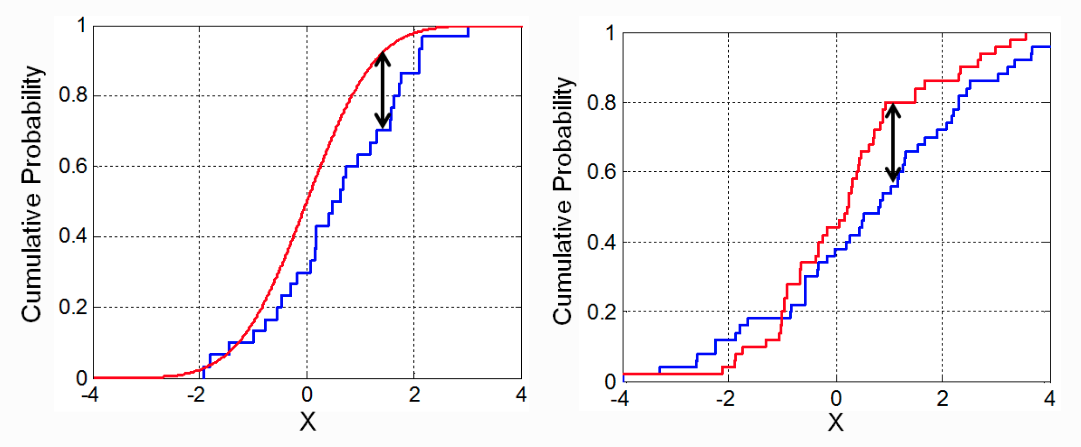

> _Izquierda: ilustración del estadístico de Kolmogorov–Smirnov. La línea roja muestra la función de distribución acumulada teórica, la azul la función de distribución acumulada empírica, y la flecha negra es el estadístico K-S. Derecha: ilustración del estadístico de Kolmogorov–Smirnov entre dos muestras. Las líneas roja y azul muestran la función de distribución acumulada empírica de dos muestras, y la flecha negra es el estadístico K-S. Fuente: Wikipedia._

## Ejemplo

Un estudio pretende determinar si ha cambiado la distribución de salarios en España entre 1989 y 1993. Para ello, se recurre a la distancia de Kolmogorov–Smirnov.

## Librerías

In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

# Modelado y test estadísticos
# ==============================================================================
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import ks_2samp

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Datos

El set de datos **Snmesp** del paquete de **R** `plm` contiene una muestra de los salarios (en escala logarítmica) pagados en España durante los años 1983 a 1990 (783 observaciones por año).

In [4]:
# Datos
# ==============================================================================
url = (
    "https://raw.githubusercontent.com/JoaquinAmatRodrigo/"
    "Estadistica-machine-learning-python/master/data/Snmesp.csv"
)
datos = pd.read_csv(url)
datos["year"] = datos["year"].astype(str)
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    1476 non-null   object 
 1   salary  1476 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.2+ KB


## Análisis gráfico

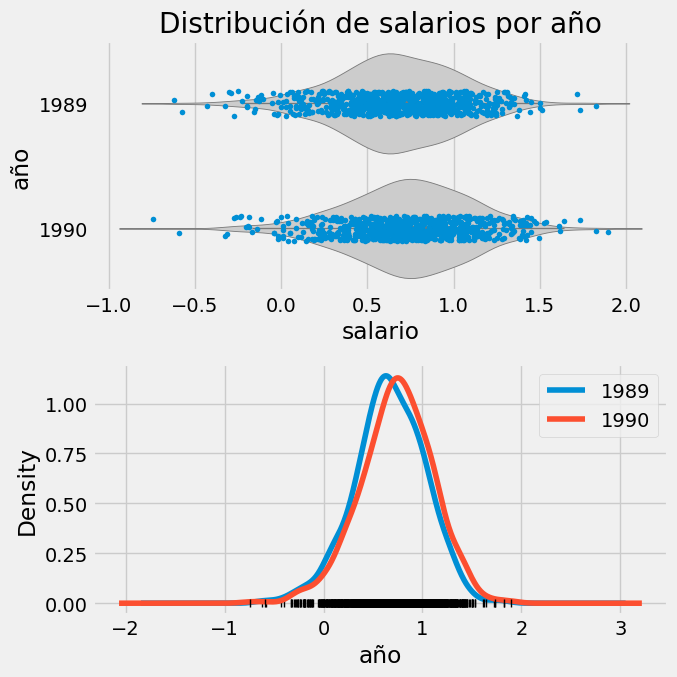

In [7]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7))
sns.violinplot(x=datos.salary, y=datos.year, color=".8", ax=axs[0])

sns.stripplot(x=datos.salary, y=datos.year, data=datos, size=4, jitter=0.1, ax=axs[0])
axs[0].set_title("Distribución de salarios por año")
axs[0].set_ylabel("año")
axs[0].set_xlabel("salario")

for year in datos.year.unique():
    datos_temp = datos[datos.year == year]["salary"]
    datos_temp.plot.kde(ax=axs[1], label=year)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), "|k", markeredgewidth=1)

axs[1].set_xlabel("año")
axs[1].legend()

fig.tight_layout()
plt.show()

## Función de distribución acumulada empírica

La clase `ECDF()` de la librería **statsmodels** permite ajustar la función de distribución acumulada empírica a partir de una muestra. El resultado de esta función es un objeto `ecdf` que se comporta de forma similar a un modelo predictivo, recibe un vector de observaciones y devuelve su probabilidad acumulada estimada.

In [8]:
# Ajuste de las funciones ecdf con cada muestra
# ==============================================================================
ecdf_1989 = ECDF(datos.loc[datos.year == "1989", "salary"])
ecdf_1990 = ECDF(datos.loc[datos.year == "1990", "salary"])

In [9]:
# Estimación de la probabilidad acumulada de cada valor de salario observado
# ==============================================================================
grid_salario = np.sort(datos.salary.unique())
prob_acumulada_ecdf_1989 = ecdf_1989(grid_salario)
prob_acumulada_ecdf_1990 = ecdf_1990(grid_salario)

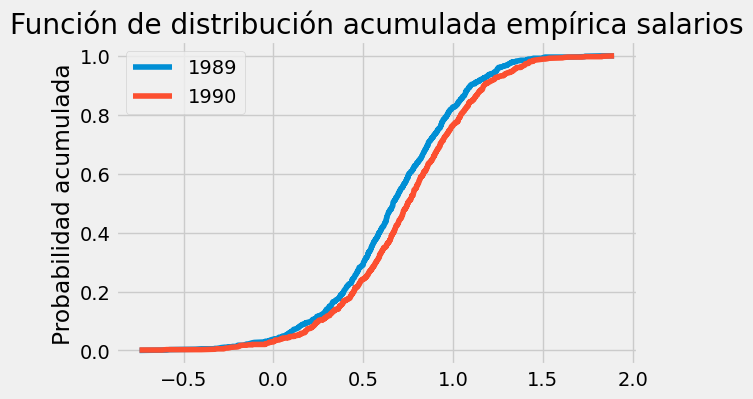

In [10]:
# Representación gráfica de las curvas ecdf
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(grid_salario, prob_acumulada_ecdf_1989, label="1989")
ax.plot(grid_salario, prob_acumulada_ecdf_1990, label="1990")
ax.set_title("Función de distribución acumulada empírica salarios")
ax.set_ylabel("Probabilidad acumulada")
ax.legend()
plt.show()

Este mismo gráfico puede generarse directamente con la función `ecdfplotp` de `seaborn`.

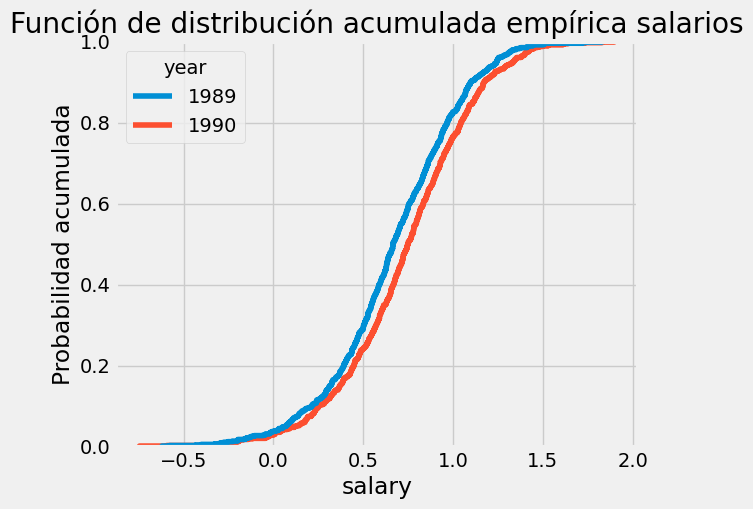

In [12]:
# Representación gráfica de las curvas ecdf
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
sns.ecdfplot(data=datos, x="salary", hue="year", ax=ax)
ax.set_title("Función de distribución acumulada empírica salarios")
ax.set_ylabel("Probabilidad acumulada")
plt.show()

### Cálculo de la distancia Kolmogorov–Smirnov

Para obtener la distancia de Kolmogorov–Smirnov, primero se calcula la diferencia absoluta entre las probabilidades acumuladas de cada una de las funciones ecdf (la diferencia absoluta entre cada punto de las curvas) y después se identifica el valor máximo.

In [13]:
# Distancia Kolmogorov–Smirnov
# ==============================================================================
abs_dif = np.abs(prob_acumulada_ecdf_1989 - prob_acumulada_ecdf_1990)
distancia_ks = np.max(abs_dif)
print(f"Distancia Kolmogorov–Smirnov: {distancia_ks :.4f}")

Distancia Kolmogorov–Smirnov: 0.1057


## Test de Kolmogorov–Smirnov

Una vez calculada la distancia de Kolmogorov–Smirnov, hay que determinar si el valor de esta distancia es suficientemente grande, teniendo en cuenta las muestras disponibles, como para considerar que las dos distribuciones son distintas. Esto puede conseguirse calculando la probabilidad (p-value) de observar distancias iguales o mayores si ambas muestras procediesen de la misma distribución, es decir, que las dos distribuciones son la misma.

El test estadístico de **Kolmogorov–Smirnov** para dos muestras está disponible en la función `ks_2samp()` de la librería **scipy.stats.** La hipótesis nula de este test considera que ambas muestras proceden de la misma distribución, por lo tanto, solo cuando el p-value estimado es muy pequeño (significativo), se puede considerar que hay evidencias en contra de que la distribución de ambas muestras es la misma.

### Ejemplo

Empleando los mismos datos del ejemplo anterior se aplica el test de Kolmogorov–Smirnov para responder a la pregunta de si la distribución del salario ha cambiado entre 1989 y 1990.

In [14]:
# Test Kolmogorov–Smirnov entre dos muestras
# ==============================================================================
ks_2samp(
    datos.loc[datos.year == "1989", "salary"], datos.loc[datos.year == "1990", "salary"]
)

KstestResult(statistic=0.10569105691056911, pvalue=0.0005205845230085144, statistic_location=0.6692902, statistic_sign=1)

Existen evidencias suficientes para considerar que la distribución de salarios ha variado de un año a otro.